In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [4]:
data_labels = pd.read_csv('training-a.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(19702, 2)


,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [ ]:
TRAIN_PATH ='Train1'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src =  folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')

In [63]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [64]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  19702


# **Base Parameters**

In [65]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_sampler) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

25


In [66]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:789
Test dataloader:197


In [67]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [68]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [70]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.3024277687072754. Accuracy: 9.263959390862944
Epoch:  2
Iteration: 1000. Loss: 2.3062901496887207. Accuracy: 9.67005076142132
Iteration: 1500. Loss: 2.299248218536377. Accuracy: 9.67005076142132
Epoch:  3
Iteration: 2000. Loss: 2.3047289848327637. Accuracy: 9.67005076142132
Epoch:  4
Iteration: 2500. Loss: 2.300363302230835. Accuracy: 9.746192893401016
Iteration: 3000. Loss: 2.297542095184326. Accuracy: 9.746192893401016
Epoch:  5
Iteration: 3500. Loss: 2.3001837730407715. Accuracy: 9.67005076142132
Epoch:  6
Iteration: 4000. Loss: 2.3037359714508057. Accuracy: 9.263959390862944
Iteration: 4500. Loss: 2.3062491416931152. Accuracy: 9.746192893401016
Epoch:  7
Iteration: 5000. Loss: 2.2998266220092773. Accuracy: 10.304568527918782
Iteration: 5500. Loss: 2.302612066268921. Accuracy: 9.263959390862944
Epoch:  8
Iteration: 6000. Loss: 2.2996628284454346. Accuracy: 9.67005076142132
Epoch:  9
Iteration: 6500. Loss: 2.303332805633545. Accuracy: 9.7461928934010

In [74]:
torch.save(model.state_dict(), 'model_base.pkl')

[2.3024277687072754, 2.3062901496887207, 2.299248218536377, 2.3047289848327637, 2.300363302230835, 2.297542095184326, 2.3001837730407715, 2.3037359714508057, 2.3062491416931152, 2.2998266220092773, 2.302612066268921, 2.2996628284454346, 2.303332805633545, 2.2985565662384033, 2.3036649227142334, 2.299359083175659, 2.297351598739624, 2.303452491760254, 2.3035244941711426, 2.2971789836883545, 2.2973058223724365, 2.2987802028656006, 2.295928478240967, 2.2969748973846436, 2.2890098094940186, 2.2816503047943115, 2.270620822906494, 2.2606072425842285, 2.248142719268799, 2.275524616241455, 2.183948278427124, 2.214792490005493, 2.031534433364868, 2.115813732147217, 2.0745017528533936, 2.4363656044006348, 2.145387887954712, 2.761197090148926, 2.084205389022827]


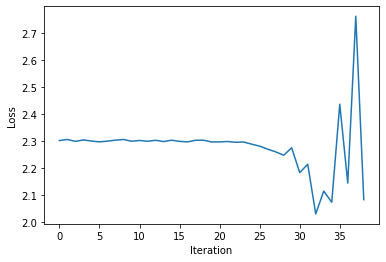

In [75]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## Approach 1:  Batch Size 200,number of hidden nodes 100 and learning rate is 0.001. CELU activation function with 4 hidden layer.


In [73]:
# Hyperparameters

batch_size = 200
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 100 # num of hidden nodes
output_dim = 10

learning_rate = 0.001  # More power so we can learn faster! previously it was 0.001

num_epochs = num_iters / (len(train_sampler) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

253


In [76]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)



split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)



train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)



print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:79
Test dataloader:20


In [77]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.celu_1 = nn.CELU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.celu_2 = nn.CELU()
        
        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.celu_3 = nn.CELU()
        
        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.celu_4 = nn.CELU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.celu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.celu_2(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.celu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.celu_4(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [78]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden
                              )
# To enable GPU
model.to(device)


DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (celu_1): CELU(alpha=1.0)
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (celu_2): CELU(alpha=1.0)
  (linear_3): Linear(in_features=100, out_features=100, bias=True)
  (celu_3): CELU(alpha=1.0)
  (linear_4): Linear(in_features=100, out_features=100, bias=True)
  (celu_4): CELU(alpha=1.0)
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [80]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Iteration: 500. Loss: 1.1498351097106934. Accuracy: 56.47208121827411
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Iteration: 1000. Loss: 0.807729959487915. Accuracy: 70.88832487309645
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Iteration: 1500. Loss: 0.5954529643058777. Accuracy: 78.02030456852792
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Iteration: 2000. Loss: 0.48603206872940063. Accuracy: 78.88324873096447
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Iteration: 2500. Loss: 0.5842519998550415. Accuracy: 82.81725888324873
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Iteration: 3000. Loss: 0.5448495745658875. Accuracy: 77.03045685279187
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Iteration: 3500. Loss: 0.489406019449234. Accuracy: 82.08121827411168
Epoch:  46
Epoch:  

In [81]:
torch.save(model.state_dict(), 'model_base.pkl1')

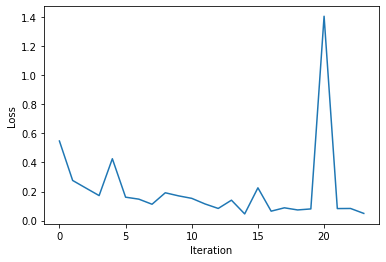

In [88]:
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## Approach 2: 

In [89]:
batch_size = 250
num_iters = 30000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_sampler) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

475


In [90]:
test_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)


split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)



train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)


print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:64
Test dataloader:16


In [91]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
        
        probas  = self.linear_out(out)
        return probas

#### INSTANTIATE MODEL CLASS

In [92]:
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden
                              )
#To enable GPU

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [94]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    #print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2963602542877197. Accuracy: 9.695431472081218
Iteration: 1000. Loss: 2.292970895767212. Accuracy: 11.776649746192893
Iteration: 1500. Loss: 2.2871947288513184. Accuracy: 12.563451776649746
Iteration: 2000. Loss: 2.282362937927246. Accuracy: 21.091370558375633
Iteration: 2500. Loss: 2.27449107170105. Accuracy: 22.81725888324873
Iteration: 3000. Loss: 2.2585811614990234. Accuracy: 25.634517766497463
Iteration: 3500. Loss: 2.1728386878967285. Accuracy: 23.426395939086294
Iteration: 4000. Loss: 2.125058174133301. Accuracy: 26.903553299492387
Iteration: 4500. Loss: 2.0830931663513184. Accuracy: 30.81218274111675
Iteration: 5000. Loss: 2.056431293487549. Accuracy: 20.380710659898476
Iteration: 5500. Loss: 1.8294837474822998. Accuracy: 34.67005076142132
Iteration: 6000. Loss: 1.8864601850509644. Accuracy: 34.974619289340104
Iteration: 6500. Loss: 1.7794727087020874. Accuracy: 29.086294416243653
Iteration: 7000. Loss: 2.108072280883789. Accuracy: 26.903553299492387
Iter

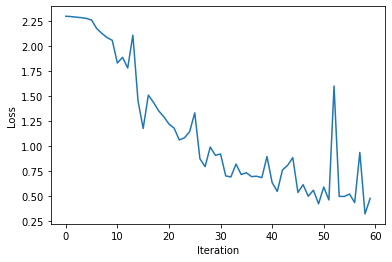

In [95]:
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()